In [1]:
import numpy as np
import pandas as pd
import datetime
import seaborn as sns
sns.set_style('white')
import matplotlib.pyplot as plt
from KalmanFilterClass import KalmanFilter

This is an example of Kalman filter.
Next step: compare to Recursive Least Squares or Constant Gain algorithms
which could be seen as special cases of Kalman filter

In [2]:
# helop function to cut time series into chunks
def cut_to_steps(data_frame, column, step):
    """Purpose: cut the time series into x and y blocks
    It will add 1 to each x block for intercept
    """
    
    # make sure index is correct
    data_frame.index = range(len(data_frame))
    
    data_x, data_y = [], []
    
    for i in range(len(data_frame)-step-1):
        temp = data_frame[column].iloc[i:(i+step)]
        temp = np.array(temp)
        temp = np.insert(temp, 0, 1)
        data_x.append(temp)
        data_y.append(data_frame[column].iloc[i+step+1])
    
    return np.array(data_x), np.array(data_y)

Generate Time Series

In [3]:
ts_values = np.random.rand(3000)

In [4]:
start_date = datetime.datetime.now().date()
end_date = start_date + datetime.timedelta(days=len(ts_values)-1)
dates = pd.date_range(start_date, end_date,  freq='D')

In [5]:
# create dataframe with dates and values
data_set = pd.DataFrame()
data_set['date'] = dates
data_set['value'] = ts_values
data_set.head()

,date,value
0,2017-06-22,0.875154
1,2017-06-23,0.767674
2,2017-06-24,0.220118
3,2017-06-25,0.712173
4,2017-06-26,0.507205


In [6]:
# estimate AR(t) process, cut the time series into chunks

In [7]:
x, y = cut_to_steps(data_set, 'value', 1)

Initialise the Filter

In [8]:
# fit the polynomial to get the initial coefficients
np_polyfit = np.polyfit(range(len(data_set)), data_set['value'], deg=1)
number_of_state_variables = len(list(np_polyfit))
previous_beta = list(np_polyfit)
prior_beta = list(np_polyfit) + np.random.randn(number_of_state_variables) * 0.05
posterior_beta = list(np_polyfit) + np.random.randn(number_of_state_variables) * 0.5
prior_p = posterior_p = np.eye(number_of_state_variables)
previous_p = prior_p
h_vec = x[0]
q_mat = 0.0015 * np.eye(number_of_state_variables)
r_parameter = 0.01
variable = y[0]
state_transition = np.array([0.99**int(i) for i in range(number_of_state_variables)])
state_transition.sort()

In [9]:
KalmanFilter = KalmanFilter(previous_beta, prior_beta,
                            posterior_beta, previous_p,
                            prior_p, posterior_p,
                            q_mat, h_vec, r_parameter,
                            variable, number_of_state_variables,
                            state_transition)

In [10]:
# run the filter
prior_parameters_forecast = []
posterior_parameters_forecast = []

prior_forecast = []
posterior_forecast = []

for j in range(1, len(y)):
    
    prior_parameters_forecast.append(KalmanFilter.kalman_filter_predict())
    prior_forecast.append(np.dot(prior_parameters_forecast[j-1], x[j-1]))
    
    KalmanFilter.variable = y[j-1]
    KalmanFilter.h_vec = x[j-1]
    
    b = KalmanFilter.kalman_filter_update()
    posterior_parameters_forecast.append(b)
    posterior_forecast.append(np.dot(b, x[j-1]))

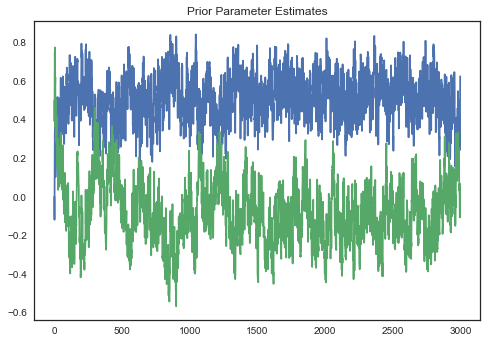

In [11]:
# plot prior parameters
plt.figure()
plt.title('Prior Parameter Estimates')
plt.plot(prior_parameters_forecast)
plt.show()

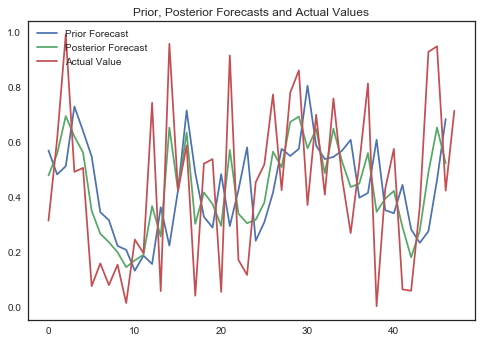

In [12]:
# plot predictions
plt.figure()
plt.plot(prior_forecast[2950:], label='Prior Forecast')
plt.plot(posterior_forecast[2950:], label='Posterior Forecast')
plt.plot(y[2950:], label='Actual Value')
plt.legend(loc='upper left')
plt.title('Prior, Posterior Forecasts and Actual Values')
plt.show()